In [1]:
from IPython.display import HTML, display
css_file_path = "../../design/custom.css"
styles = "<link rel='stylesheet' href='%s'>" % css_file_path
display(HTML(styles))

# Python aplicado a la Gestión de Carteras

## SIMULACIONES DE MONTECARLO DE UNA CARTERA CON MUCHOS ACTIVOS

In [7]:
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp

from utils import dibuja_covar

plt.style.use('ggplot')

Vamos a utilizar el índice S&P500 para obtener la cartera con mínima varianza y, a partir de ahí, generar las simulaciones de Montecarlo siguiendo dos estrategias diferentes:

* Considerar la cartera como un único activo y volver a la simulación del TEMA 1

* Considerar la combinación de los activos que componen la cartera

### Carga de datos

Descargamos los datos de S&P500

In [3]:
sp_500_df = pd.read_excel('../data/SP500_comp_data.xlsx', index_col=0, parse_dates=True)

num_min = 2000 # Número mínimo de datos
sp_500_df = sp_500_df.dropna(axis=1, thresh=num_min)
sp_500_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,0.332589,NaN,NaN,3.885798,NaN,NaN,1.265625,...,NaN,20.2500,12.5000,1.041667,NaN,NaN,NaN,NaN,3.5000,NaN
1990-01-03,NaN,NaN,NaN,0.334821,NaN,NaN,3.899826,NaN,NaN,1.328125,...,NaN,20.1875,12.3750,1.041667,NaN,NaN,NaN,NaN,3.5625,NaN
1990-01-04,NaN,NaN,NaN,0.335938,NaN,NaN,3.892812,NaN,NaN,1.390625,...,NaN,19.6875,12.2500,1.000000,NaN,NaN,NaN,NaN,3.5625,NaN
1990-01-05,NaN,NaN,NaN,0.337054,NaN,NaN,3.850728,NaN,NaN,1.421875,...,NaN,19.5000,12.1875,1.062500,NaN,NaN,NaN,NaN,3.5625,NaN
1990-01-08,NaN,NaN,NaN,0.339286,NaN,NaN,3.850728,NaN,NaN,1.437500,...,NaN,19.3125,12.3750,1.020833,NaN,NaN,NaN,NaN,3.5625,NaN


In [4]:
# Calcular los retornos logarítmicos usando diff()
ret_sp500_df = np.log(sp_500_df).diff().dropna()

ret_sp500_df.head()  # Mostrar las primeras filas de los retornos logarítmicos

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-07,0.010866,0.023384,0.000673,-0.002463,0.004971,0.005539,0.009405,0.003026,0.013672,0.001117,...,0.069442,0.028432,0.004111,0.006730,0.003580,-0.008640,0.008968,0.004283,-0.021060,-0.010802
2015-07-08,-0.026485,-0.034012,-0.021885,-0.025136,-0.013214,-0.007392,-0.019305,-0.007364,-0.010800,-0.007473,...,-0.066942,-0.005325,-0.010920,-0.018179,-0.022517,-0.031300,-0.016812,-0.034878,-0.026208,-0.029676
2015-07-09,0.004377,0.009116,0.012917,-0.020607,0.004571,0.009507,-0.001219,-0.005522,0.001331,0.005983,...,0.010127,-0.011337,-0.004524,-0.007640,-0.000844,0.009937,-0.010243,-0.000277,0.021942,0.001934
2015-07-10,0.012258,0.038086,0.012509,0.026383,0.018368,0.005497,0.014932,0.011303,0.010482,0.001490,...,-0.012434,0.006579,0.007569,0.011536,-0.004230,0.032097,-0.000281,0.012008,0.020183,0.008340
2015-07-13,0.014113,0.028939,0.031194,0.019122,0.004899,0.005557,-0.004215,-0.006940,0.017760,0.010492,...,0.037683,-0.000298,0.002430,0.014858,0.018755,0.002748,0.007648,0.006901,0.008983,0.001702


### Cálculo de la cartera de mínima varianza

Definimos la función que calcula la cartera de menor volatilidad y devuelve la volatilidad de la cartera y los pesos de cada activo. Por ahora **no entramos en los detalles de esta función**, lo veremos en el **TEMA 3**.

In [8]:
def calc_port_min_var(retornos):
    '''
    Calcula la cartera de mínima varianza
    retornos: matriz de retornos
    w: pesos de la cartera
    vol_min: volatilidad de la cartera
    '''
    n_days, n_act = retornos.shape
    w = cp.Variable(n_act)
    cov = np.cov(retornos.T)  
    objective = cp.Minimize(w.T @ cov @ w)
    const= [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(objective, const)
    port_min_var = prob.solve()
    vol_min = np.sqrt(port_min_var)
    return vol_min, w.value

In [9]:
num_act_sp500 = ret_sp500_df.shape[1] #número de activos

# Calculamos la cartera de mínima varianza para cada número de activos

var_min_sp500, pesos_sp500 = calc_port_min_var(ret_sp500_df) #calculamos la cartera de mínima varianza

A partir de aquí, la variable `pesos_sp500` guarda los pesos de la cartera con mínima varianza.

### 1. Considerar la cartera como un único activo

Calculamos los retornos diarios de la cartera de mínima varianza:

In [14]:
tmp_cart = ret_sp500_df @ pesos_sp500.T #calculamos los retornos de la cartera de mínima varianza
tmp_cart.shape

(2047,)

A partir de los retornos diarios, calculamos los precios de la cartera para visualizarlos:

In [15]:
precios_cart = 1.0 * np.exp(np.cumsum(tmp_cart))
precios_cart.shape

(2047,)

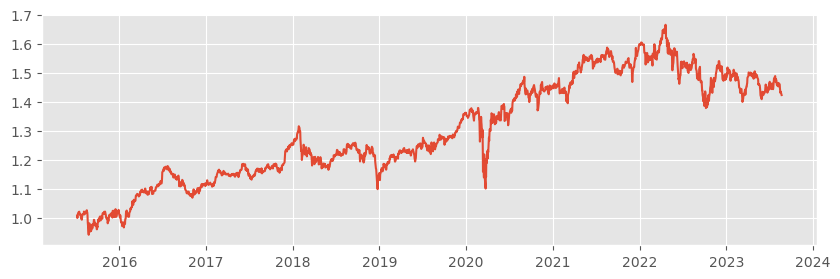

In [17]:
plt.figure(figsize=(10,3))
plt.plot(precios_cart)
plt.show()

Generamos 100 simulaciones de 252 días utilizando la media y desviación estandar de los retornos de la cartera:

In [59]:
num_simulaciones = 100
num_dias = 252

media = tmp_cart.mean()
std = tmp_cart.std()
ret_montecarlo = np.random.normal(media, std, (num_simulaciones, num_dias))
ret_montecarlo.shape

(100, 252)

A partir de los retornos generados con Montecarlo, calculamos los precios para dibujarlos:

In [60]:
precio_ini = precios_cart[-1] 
precios_montecarlo = precio_ini * np.exp(ret_montecarlo.cumsum(axis=1))
precios_montecarlo.shape

(100, 252)

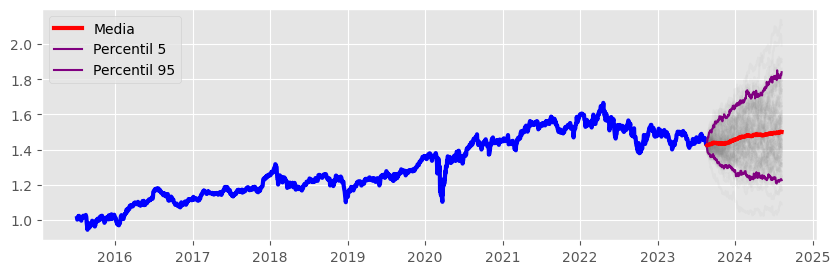

In [61]:
index = pd.date_range(precios_cart.index[-1], periods=num_dias, freq='B')

plt.figure(figsize=(10,3))
plt.plot(precios_cart, color="blue", linewidth=3)
plt.plot(index, precios_montecarlo.T, color="gray", alpha=0.05)
plt.plot(index, precios_montecarlo.mean(axis=0), color="red", linewidth=3, label="Media")
plt.plot(index, np.percentile(precios_montecarlo, 5, axis=0), color="purple", label="Percentil 5")
plt.plot(index, np.percentile(precios_montecarlo, 95, axis=0), color="purple", label="Percentil 95")
plt.legend()
plt.show()

**Pregunta** ¿Qué sucede si no utilizamos toda la serie temporal desde 2015 para calcular los retornos? ¿Cómo serán nuestras simulaciones?

---

### 2. Considerar la combinación de activos que componen la cartera

Veamos ahora las diferencias para simular con Montecarlo una cartera cuando planteamos la combinación de activos. 

Para poder generar la simulación de Montecarlo, necesitamos generar números aleatorios a partir de los activos, utilizando sus medias y la matriz de covarianzas entre ellos.

In [71]:
retornos_medios = ret_sp500_df.mean(axis=0)
matriz_covar = ret_sp500_df.cov()

Con el siguiente código generamos retornos siguiendo una matriz de covarianzas utilizando la función **np.random.multivariate_normal** de `numpy`.

In [75]:
# Verificar si la matriz es positiva semi-definida
if np.all(np.linalg.eigvals(matriz_covar) >= 0):
    print("La matriz es positiva semi-definida.")
else:
    print("La matriz no es positiva semi-definida. Ajuste los valores.")

# Número de simulaciones
n_simulaciones = 100
n_dias = 252

# Generar retornos aleatorios
retornos_simulados = np.random.multivariate_normal(mean=retornos_medios,
                                                   cov=matriz_covar,
                                                   size=(n_simulaciones, n_dias))

print(retornos_simulados.shape) # (n_simulaciones, n_dias, n_activos)

La matriz es positiva semi-definida.
(100, 252, 483)


Por último, calculamos los retornos de la cartera de mínima varianza:

In [80]:
sp_500_df.iloc[-1].shape

(483,)

In [77]:
rets_montecarlo = retornos_simulados @ pesos_sp500.T
rets_montecarlo.shape

(100, 252)

In [81]:
precio_ini = precios_cart[-1] 
precios_montecarlo = precio_ini * np.exp(rets_montecarlo.cumsum(axis=1))
precios_montecarlo.shape

(100, 252)

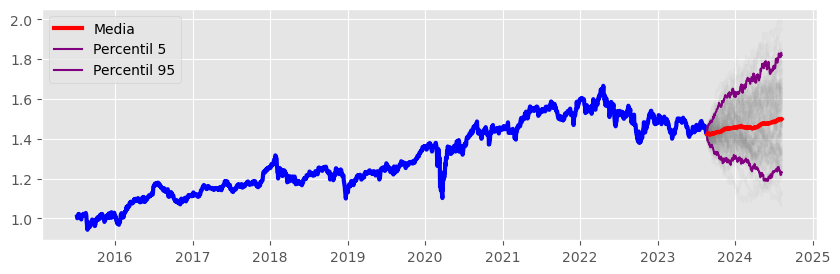

In [82]:
index = pd.date_range(precios_cart.index[-1], periods=num_dias, freq='B')

plt.figure(figsize=(10,3))
plt.plot(precios_cart, color="blue", linewidth=3)
plt.plot(index, precios_montecarlo.T, color="gray", alpha=0.05)
plt.plot(index, precios_montecarlo.mean(axis=0), color="red", linewidth=3, label="Media")
plt.plot(index, np.percentile(precios_montecarlo, 5, axis=0), color="purple", label="Percentil 5")
plt.plot(index, np.percentile(precios_montecarlo, 95, axis=0), color="purple", label="Percentil 95")
plt.legend()
plt.show()

Como podemos observar, se obtiene un resultado similar al anterior. 

**Pregunta**: ¿Para qué queremos calcularlo a partir de los retornos de los activos en lugar de considerarlo un único activo?

---

### Modificamos la matriz de covarianzas

Ayuda con modificar la matriz de covarianzas. ¿Queremos mostrarlo?

In [98]:
retornos_medios = ret_sp500_df.mean(axis=0)
matriz_covar = ret_sp500_df.cov()